<h1 align="center">Visualization of Segmentation and Registration Results</h1>

In this notebook we illustrate various ways one can display the results of segmentation and registration algorithms so that they can be easily incorporated into a manuscript. For interactive data exploration we recommend using dedicated programs (e.g. 3D slicer). 

Two key points to remember when working with bio-medical images:

1. Most often images have a high dynamic range. Thus, to write them to file in a format appropriate for use in a manuscript we will need to map the intensities to a low dynamic range (e.g. [0,255]). In SimpleITK this is readily done with the [IntensityWindowingImageFilter](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1IntensityWindowingImageFilter.html).
2. Images may have non-isotropic spacing between pixels. The file formats appropriate for use in a manuscript (e.g. png, jpg) assume isotropic pixel spacing. This requires that we resample the image before writing to disk. The function `make_isotropic` in the code cell bellow resolves this issue. 

The following filters and their procedural counterparts are useful for various image creation tasks, as illustrated in this notebook:
 * [CastImageFilter](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1CastImageFilter.html)
 * [ResampleImageFilter](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1ResampleImageFilter.html), one of the more important filters in your toolbox, see [this notebook](21_Transforms_and_Resampling.ipynb) for additional usage details.
 * [TileImageFilter](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1TileImageFilter.html)
 * [CheckerBoardImageFilter](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1CheckerBoardImageFilter.html)
 * [ComposeImageFilter](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1ComposeImageFilter.html)
 * [LabelToRGBImageFilter](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1LabelToRGBImageFilter.html)
 * [ScalarToRGBColormapImageFilter](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1ScalarToRGBColormapImageFilter.html)
 * [LabelOverlayImageFilter](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1LabelOverlayImageFilter.html)
 * [LabelContourImageFilter](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1LabelContourImageFilter.html)
 * [LabelMapContourOverlayImageFilter](https://itk.org/SimpleITKDoxygen/html/namespaceitk_1_1simple.html#a4f6af69f85171e44bcff90d7860d456e)

In [1]:
%matplotlib notebook

import numpy as np

import SimpleITK as sitk
# Utility method that either downloads data from the Girder repository or
# if already downloaded returns the file name for reading from disk (cached data).
%run update_path_to_download_script
from downloaddata import fetch_data as fdata


import gui

# Always write output to a separate directory, we don't want to pollute the source directory. 
import os
OUTPUT_DIR = 'Output'

def make_isotropic(image, interpolator = sitk.sitkLinear):
    '''
    Resample an image to isotropic pixels (using smallest spacing from original) and save to file. Many file formats 
    (jpg, png,...) expect the pixels to be isotropic. By default the function uses a linear interpolator. For
    label images one should use the sitkNearestNeighbor interpolator so as not to introduce non-existant labels.
    '''
    original_spacing = image.GetSpacing()
    # Image is already isotropic, just return a copy.
    if all(spc == original_spacing[0] for spc in original_spacing):
        return sitk.Image(image)
    # Make image isotropic via resampling.
    original_size = image.GetSize()
    min_spacing = min(original_spacing)
    new_spacing = [min_spacing]*image.GetDimension()
    new_size = [int(round(osz*ospc/min_spacing)) for osz,ospc in zip(original_size, original_spacing)]
    return sitk.Resample(image, new_size, sitk.Transform(), interpolator,
                         image.GetOrigin(), new_spacing, image.GetDirection(), 0,
                         image.GetPixelID())

# Combining two images

There are a variety of ways we can overlay two (partially) overlapping images onto each other. The common approaches include:
1. Use of alpha blending.
2. Use of a checkerboard pattern with the pixel values in adjacent squares/boxes taken from each of the images.
3. When the pixel values are scalars (gray scale images), combine the two images in different channels, resulting in a color image.

We will start by loading two images whose content luckily overlaps in physical space. Before we can combine the two, we need to resample one of them so that they both occupy the same spatial region. In addition we should also rescale the intensities so that they occupy the same range. In our case we will map them to [0,255], based on the desired windowing.

Fetching training_001_mr_T1.mha
Fetching training_001_ct.mha


<IPython.core.display.Javascript object>


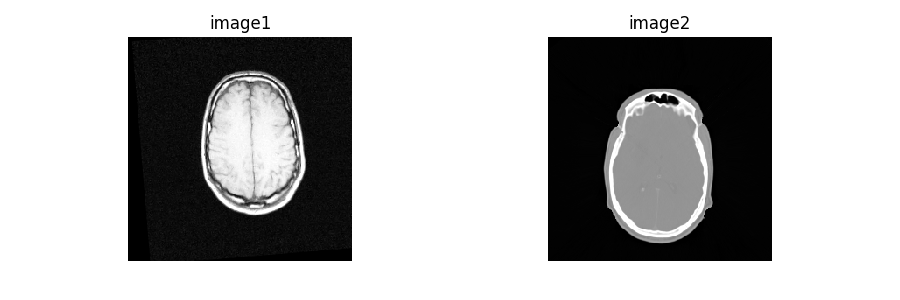

In [2]:
img1 = sitk.ReadImage(fdata("training_001_mr_T1.mha"))
img2_original = sitk.ReadImage(fdata("training_001_ct.mha"))
img2 = sitk.Resample(img2_original, img1)

# Obtain foreground masks for the two images using Otsu thresholding, we use these later on.
msk1 = sitk.OtsuThreshold(img1,0,1)
msk2 = sitk.OtsuThreshold(img2,0,1)

gui.MultiImageDisplay(image_list = [img1, img2],                   
                      title_list = ['image1', 'image2'],
                      figure_size=(9,3));

In [3]:
# Having identified the desired intensity range for each of the 
# images using the GUI above, we use these values to perform intensity windowing and map the intensity values
# to [0,255] and cast to 8-bit unsigned int
img1_255 = sitk.Cast(sitk.IntensityWindowing(img1, windowMinimum=2, windowMaximum=657, 
                                             outputMinimum=0.0, outputMaximum=255.0), sitk.sitkUInt8)
img2_255 = sitk.Cast(sitk.IntensityWindowing(img2, windowMinimum=-1018, windowMaximum=1126, 
                                             outputMinimum=0.0, outputMaximum=255.0), sitk.sitkUInt8)

## Alpha blending

Alpha blending combines the pixels from the two images as follows:
$$
I_{output} = \alpha I_1 + (1-\alpha)I_2,\;\;\; \alpha \in[0.0,1.0]
$$

When our images consist of a foreground and background we can use alpha blending in a manner that takes this into account. Instead of blending all of the pixels using the formula above, we use this formula only in the regions where the foregrounds overlap. In regions where the foreground from one image overlaps with the background of the other we simply copy the foreground. This improves visibility as we are not blending a region that contains information with an empty region.

The code below allows us to experiment with various alpha blending strategies.

In [4]:
def mask_image_multiply(mask, image):
    components_per_pixel = image.GetNumberOfComponentsPerPixel()
    if  components_per_pixel == 1:
        return mask*image
    else:
        return sitk.Compose([mask*sitk.VectorIndexSelectionCast(image,channel) for channel in range(components_per_pixel)])

def alpha_blend(image1, image2, alpha = 0.5, mask1=None,  mask2=None):
    '''
    Alaph blend two images, pixels can be scalars or vectors.
    The region that is alpha blended is controled by the given masks.
    '''
    
    if not mask1:
        mask1 = sitk.Image(image1.GetSize(), sitk.sitkFloat32) + 1.0
        mask1.CopyInformation(image1)
    else:
        mask1 = sitk.Cast(mask1, sitk.sitkFloat32)
    if not mask2:
        mask2 = sitk.Image(image2.GetSize(),sitk.sitkFloat32) + 1
        mask2.CopyInformation(image2)
    else:        
        mask2 = sitk.Cast(mask2, sitk.sitkFloat32)

    components_per_pixel = image1.GetNumberOfComponentsPerPixel()
    if components_per_pixel>1:
        img1 = sitk.Cast(image1, sitk.sitkVectorFloat32)
        img2 = sitk.Cast(image2, sitk.sitkVectorFloat32)
    else:
        img1 = sitk.Cast(image1, sitk.sitkFloat32)
        img2 = sitk.Cast(image2, sitk.sitkFloat32)
        
    intersection_mask = mask1*mask2
    
    intersection_image = mask_image_multiply(alpha*intersection_mask, img1) + \
                         mask_image_multiply((1-alpha)*intersection_mask, img2)
    return intersection_image + mask_image_multiply(mask2-intersection_mask, img2) + \
           mask_image_multiply(mask1-intersection_mask, img1)

We now create 3D images using all four combinations of alpha-blending and masks. As we are working with a 3D image and we want to save it as a figure for use in a manuscript, we will create a 2D montage image using the axial slices from the volumes.

<IPython.core.display.Javascript object>


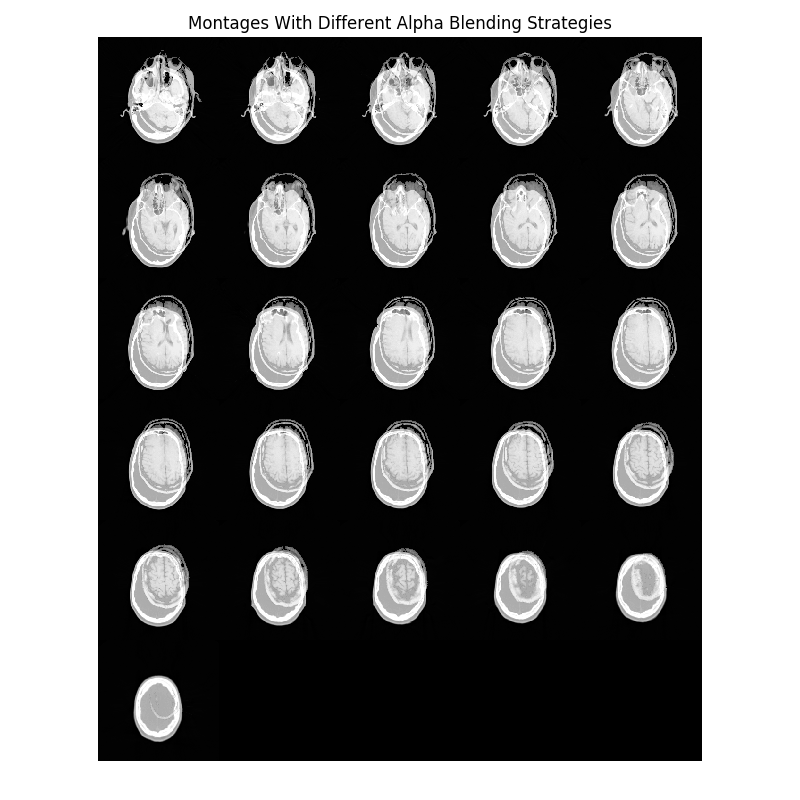

In [5]:
# Combine the two volumes
images_list = [(alpha_blend(img1_255, img2_255), 'alpha_blend_standard'), 
               (alpha_blend(img1_255, img2_255, mask1=msk1), 'alpha_blend_mask1'),
               (alpha_blend(img1_255, img2_255, mask2=msk2),'alpha_blend_mask2'),
               (alpha_blend(img1_255, img2_255, mask1=msk1, mask2=msk2),'alpha_blend_mask1_mask2')]

# Tile the volumes using the x-y plane (axial slices)
all_montages = []
for img,img_name in images_list:
    num_slices = img.GetDepth()
    tile_w = int(np.sqrt(num_slices))
    tile_h = int(np.ceil(num_slices/tile_w))
    tile_image = sitk.Tile([img[:,:,i] for i in range(num_slices)], (tile_w, tile_h))
    sitk.WriteImage(sitk.Cast(tile_image, sitk.sitkUInt8), os.path.join(OUTPUT_DIR,img_name+'.png'))
    all_montages.append(tile_image)

# Display all montages by combining them into a faux volume. Notice that scrolling through this
# volume creates the illusion of motion due to the change in intensities (the interested
# reader is referred to "Visual dissociations of movement, position, and stereo depth: Some phenomenal 
# phenomena", R. L. Gregory, P. F. Heard).
gui.MultiImageDisplay(image_list = [sitk.JoinSeries(all_montages)],
                      title_list = ['Montages With Different Alpha Blending Strategies'],
                      figure_size=(8,8));

## Checkerboard

Combine the original and the intensity windowed images using the checkerboard pattern. This illustrates the need to map both images to the same intensity range. This is particularly visible in the background region, where both images contain air. 

You can specify the number of checkerboard tiles per dimension as illustrated below. The actual number of checkerboard tiles depends on the number of pixels per dimension and the specified number of tiles. You may get more tiles than specified, for example try specifying [4,4,7] below.

<IPython.core.display.Javascript object>


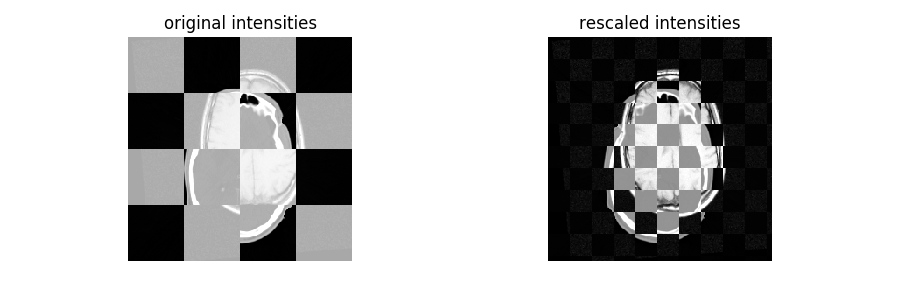

In [6]:
gui.MultiImageDisplay(image_list = [sitk.CheckerBoard(img1, img2, [4,4,4]), sitk.CheckerBoard(img1_255, img2_255, (10,10,4))],
                      title_list = ['original intensities', 'rescaled intensities'],
                      figure_size=(9,3));

## Combine scalar images to create color image

There are a variety of ways we can combine the scalar images to create a color image. Some of these combinations should be avoided as they are not discernible by a significant portion of the population (i.e. red-green channel encoding). For additional details see:

M. Geissbuehler, T. Lasser, "How to display data by color schemes compatible with red-green color perception deficiencies", Opt Express., 21(8):9862-74, 2013.  




<IPython.core.display.Javascript object>


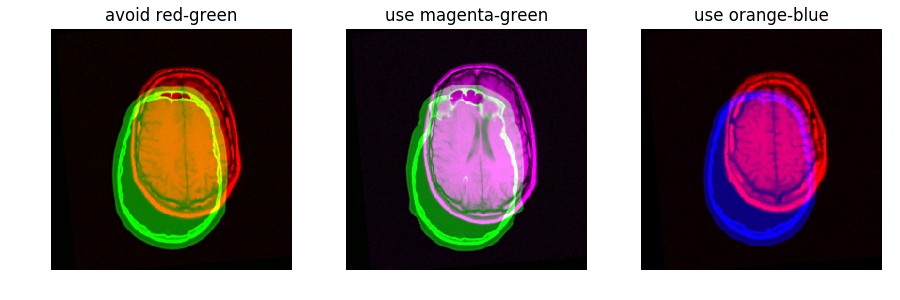

In [7]:
zeros = sitk.Image(img1_255.GetSize(), img1_255.GetPixelID())
zeros.CopyInformation(img1_255)

gui.MultiImageDisplay(image_list = [sitk.Cast(sitk.Compose(img1_255, img2_255, zeros), sitk.sitkVectorUInt8),
                                    sitk.Cast(sitk.Compose(img1_255, img2_255, img1_255), sitk.sitkVectorUInt8),
                                   sitk.Cast(sitk.Compose(img1_255, 0.5*img1_255+0.5*img2_255, img2_255), sitk.sitkVectorUInt8)],
                      title_list= ['avoid red-green', 'use magenta-green', 'use orange-blue'],
                      figure_size=(9,3));

## Overlay scalar image onto another via color map

In some situations we have an underlying image (spatial structures) and we want to overlay a scalar based pseudo-color image on top of it.

This is relevant for presenting co-registered PET/CT data, with the PET providing functional information and the CT providing the underlying spatial structures. A similar use case in the context of deep learning is to display activation maps illustrating the regions in an image on which the network is focusing its attention for the particular class.

The two main decisions we make are:
1. Selection of pseudo-color scheme using the [ScalarToRGBColormapImageFilter](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1ScalarToRGBColormapImageFilter.html) which supports a variety of color maps.
2. Alpha blending approach (alpha value and usage of masks as done above).


In [16]:
# Create a signed distance map which we will overlay onto the original image using 
# pseudo-coloring. We are only interested in locations that are at a distance of [0,512] from the object 
distance_map = sitk.SignedMaurerDistanceMap(msk1)
# Get binary region of interest mask.
roi = sitk.Cast(distance_map>0.0, sitk.sitkFloat32)*sitk.Cast(distance_map<512.0, sitk.sitkFloat32)
roi_distance_map = roi*distance_map
overlay_color_img = sitk.ScalarToRGBColormap(roi_distance_map, 
                                             sitk.ScalarToRGBColormapImageFilter.Jet)

# Combine the color overlay volume with the spatial structure volume using alpha blending
# and cast to a three component vector 8 bit unsigned int. We can readily incorporate a
# mask into the blend (pun intended). By adding mask2=roi we can limit the overlay to
# the region of interest.
combined_volume = sitk.Cast(alpha_blend(sitk.Compose(img1_255, img1_255, img1_255), 
                                        overlay_color_img), 
                            sitk.sitkVectorUInt8)

# Given a volume we can either create a montage as above or we can take a representative
# slice (axial/sagittal/coronal). As image formats used in manuscripts assume isotropic 
# pixels we need to ensure this before we write to disk.
all_central_slices = [combined_volume[:,:,int(combined_volume.GetDepth()/2.0 + 0.5)],
                      combined_volume[:,int(combined_volume.GetHeight()/2.0 + 0.5),:],
                      combined_volume[int(combined_volume.GetWidth()/2.0 + 0.5),:,:]]

print(sitk.GetArrayFromImage(all_central_slices[1]).shape)

(26, 256, 3)


In [8]:
# Resample to isotropic pixels and write to file.
for i, img in enumerate(all_central_slices):
    all_central_slices[i] = make_isotropic(img)
    sitk.WriteImage(all_central_slices[i], 
                    os.path.join(OUTPUT_DIR,'color_overlay{0}.png'.format(i)))
    
gui.multi_image_display2D([sitk.Tile(all_central_slices,(1,3))],  
                          figure_size=(4,4),horizontal=False);

RuntimeError: Exception thrown in SimpleITK Tile: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:209:
sitk::ERROR: Pixel type: vector of 8-bit unsigned integer is not supported in 2D byN3itk6simple15TileImageFilterE

# Combining an image and segmentation

To display the results of segmentation in context, we need to overlay them onto the original image. There are two common options for doing this:
  1. Map the segmentation labels to a color image and alpha blend onto the original image.
  2. Overlay the segmentation boundaries onto the original image.

We illustrate both approaches below.

For this example we use the Point-validated Pixel-based Breathing Thorax Model (POPI) model. The model is provided by the Léon Bérard Cancer Center & CREATIS Laboratory, Lyon, France. The relevant publication is:

J. Vandemeulebroucke, D. Sarrut, P. Clarysse, "The POPI-model, a point-validated pixel-based breathing thorax model", Proc. XVth International Conference on the Use of Computers in Radiation Therapy (ICCR), Toronto, Canada, 2007.

In [ ]:
# Load utilities that are specific to the POPI data, the label values associated with the segmentation.
%run popi_utilities_setup.py

img = sitk.ReadImage(fdata('POPI/meta/00-P.mhd'))
segmentation = sitk.ReadImage(fdata('POPI/masks/00-air-body-lungs.mhd'))

gui.MultiImageDisplay(image_list = [img, segmentation, sitk.LabelToRGB(segmentation)],                   
                      title_list = ['image', 'raw segmentation labels', 'segmentation labels in color'],
                      figure_size=(9,3), shared_slider=True);

We will work with the central coronal slice from this dataset.

In [ ]:
# Identify the desired intensity range for our image using the GUI above, mapping the high dynamic range
# image to a low dynamic range, [0,255], extract the central coronal slice and we flip it for display purposes.
coronal_255 = sitk.Cast(sitk.IntensityWindowing(img[:,int(img.GetHeight()/2),:][:,::-1], 
                                                windowMinimum=-1000, windowMaximum=170, 
                                                outputMinimum=0.0, outputMaximum=255.0), sitk.sitkUInt8)
coronal_255_isotropic = make_isotropic(coronal_255)

coronal_segmentation = segmentation[:,int(segmentation.GetHeight()/2),:][:,::-1]
# Use nearest neighbor interpolation for a label image.
coronal_segmentation_isotropic = make_isotropic(coronal_segmentation, sitk.sitkNearestNeighbor)

In many cases the values in a label image are not appropriate for direct display. For instance the values in our
label image are 0,1,2. You can see the values if you hover your cursor over the raw segmentation label image above (figure's bottom right corner). 

In theory we could map these intensities to [0,255] and save the image. In practice we may have more than 256 labels and therefor it is preferable to map the labels to colors and save the color image.

In [ ]:
# Use the default color map when mapping labels to colors and write the image.
sitk.WriteImage(sitk.LabelToRGB(coronal_segmentation_isotropic),os.path.join(OUTPUT_DIR, 'coronal_segmentation.png'))

## Overlay segmentation labels onto original image

SimpleITK allows you to overlay the segmentation labels onto the original image using a color map and alpha blending. You can specify the value for alpha blending, the color map (there is a default color map), and the background label value which will not be overlaid with a label.

The color map in SimpleITK is a set of values in the RGB color space strung together. For example [255, 0, 0, 0, 255, 0] is a two entry color map with red and green. To create a human readable color map, use lists to represent the colors and string them together, as done below.

In [ ]:
# Overlay the segmentation using default color map and an alpha value of 0.5
coronal_combined1 = sitk.LabelOverlay(image=coronal_255_isotropic, 
                                     labelImage=coronal_segmentation_isotropic,
                                     opacity=0.5, backgroundValue=air_label)

# Create an "interesting" color map and specify backgroundValue to a non existent label
# so that the background label is also overlaid.
pink= [255,105,180]
green = [0,255,0]
gold = [255,215,0]
coronal_combined2 = sitk.LabelOverlay(image=coronal_255_isotropic, 
                                     labelImage=coronal_segmentation_isotropic,
                                     opacity=0.5, backgroundValue = -1.0,
                                     colormap=pink+green+gold)

# Display the two images as a faux volume, JoinSeries, approach.
gui.MultiImageDisplay(image_list = [sitk.JoinSeries([coronal_combined1, coronal_combined2])],                   
                      title_list = ['overlaid labels'],
                      figure_size=(9,3), shared_slider=True);

## Overlay segmentation boundaries onto original image

We can readily obtain the segmentation boundaries from the raw segmentation. We then either just save the contours as an image or we can directly overly them onto the image. 

Some points to note:
 1. When working with 3D images and segmentations, our boundaries are surfaces. When these surfaces are intersected  with 2D planes they may define a region and not a contour, which is what we usually expect (e.g. slice 24 in the results displayed by the following code cell).
 2. When the labels are next to each other, they share a boundary. As a consequence, drawing the boundaries may result in contours overwriting each other or in contour crossings.

In [ ]:
red = [255,0,0]
green = [0,255,0]
blue = [0,0,255]

# red goes to the first label, green to second, blue to third
# body_label=0, air_label=1, lung_label=2 
contour_image = sitk.LabelToRGB(sitk.LabelContour(segmentation, fullyConnected=True, backgroundValue=255), 
                                colormap=red+green+blue , backgroundValue=255)
gui.MultiImageDisplay(image_list = [contour_image],                   
                      figure_size=(9,3));

In the following code cell we overlay the contours onto the original image. We use a filter that is intended for usage with a label-map image as opposed to a label image. The former is a more efficient data structure for representing segmentations (run length encoded). We therefor need to cast the label image to a label-map image.
We can also set several visualization related parameters such as overlay opacity, contour thickness, priority of overlay (which label overwrites which if they overlap) etc.

In [ ]:
contour_overlaid_image = sitk.LabelMapContourOverlay(sitk.Cast(coronal_segmentation_isotropic, sitk.sitkLabelUInt8), 
                                                     coronal_255_isotropic, 
                                                     opacity = 1, 
                                                     contourThickness=[4,4],
                                                     dilationRadius= [3,3],
                                                     colormap=red+green+blue)
gui.multi_image_display2D([contour_overlaid_image], figure_size=(6,3));

# Comparing two segmentations

In this section we show how to create a binary image illustrating all the locations where two segmentations differ. This is a trivial one liner in SimpleITK.

The following cell modifies our original coronal segmentation by dilating the body region in the top half of the image and dilating the lung region in the bottom half of the image.

In [ ]:
binary_dilate_filter = sitk.BinaryDilateImageFilter()
binary_dilate_filter.SetKernelRadius(2)
mid_size = int(coronal_segmentation_isotropic.GetHeight()/2)

# Over-segment the body region on the upper image region.
binary_dilate_filter.SetForegroundValue(body_label)
top_segmentation = binary_dilate_filter.Execute(coronal_segmentation_isotropic[:,0:mid_size])
# Over-segment the lung region on the lower image region.
binary_dilate_filter.SetForegroundValue(lung_label)
bottom_segmentation = binary_dilate_filter.Execute(coronal_segmentation_isotropic[:,mid_size:])

modified_segmentation = sitk.Tile(top_segmentation,bottom_segmentation, (1,2))
modified_segmentation.CopyInformation(coronal_segmentation_isotropic)
# Faux volume which allows us to visually compare the two segmentations by switching back and
# forth between them.
gui.MultiImageDisplay(image_list = [sitk.JoinSeries(coronal_segmentation_isotropic, modified_segmentation)],                   
                      figure_size=(6,3));

To see where the two segmentations differ, we directly compare them. If we don't want to waste ink, we can invert the result so that black pixels are the foreground and white the background. 

In [ ]:
diff_image = (coronal_segmentation_isotropic!=modified_segmentation)
sitk.WriteImage(diff_image*255, os.path.join(OUTPUT_DIR,'segmentation_differences.jpg'))
sitk.WriteImage((diff_image!=1)*255, os.path.join(OUTPUT_DIR,'segmentation_differences_inverted.jpg'))